# Detector Gain

In [1]:
%matplotlib inline

from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt

In [2]:
image = fits.getdata('./480grp_Z/480_2018_.Flat.162S0X1.Sky.52.fits').astype(np.int32)
print(image.shape)
print('')
print(image)

(1472, 2184)

[[54021 55765 55710 ... 36840 36591 32441]
 [58847 58797 58631 ... 41336 40792 36252]
 [58140 61662 61566 ... 42051 41582 36747]
 ...
 [60014 65535 65535 ... 37450 37446 33137]
 [59875 65535 65535 ... 37877 36735 32386]
 [59526 65535 65535 ... 33089 32391 29478]]


## Load Images
Using the `fits.getdata` function, Load the two flat images and two bias images that you will use to calculate the gain. Remember to put `.astype(np.int32)` at the end

In [3]:
flat1 = fits.getdata('./480grp_Z/480_2018_.Flat.162S0X1.Sky.52.fits').astype(np.int32)
flat2 = fits.getdata('./480grp_Z/480_2018_.Flat.126S0X1.Sky.54.fits').astype(np.int32)
bias1 = fits.getdata('./480grp_Z/480_2018_.Bias(0.0S0X1).70.fits').astype(np.int32)
bias2 = fits.getdata('./480grp_Z/480_2018_.Bias(0.0S0X1).71.fits').astype(np.int32)

You can write Equation 3 in code much like it appears in the instructions. You can make variables that are the same as the variables in the equation.

* For the mean: `mean_f1 = np.mean(flat1)`
* For the squared standard deviation of the image difference ($\sigma^2$): `sigma_f1f2 = np.std(flat_1 - flat_2)`

In the cell below, write out the equation. Use parentheses to ensure the correct order of operations.

## Working with Subregions
Is your gain value close to the manufacturer's specification (1.3 e-/ADU)? What happens when you calculate the gain for a subregion of the detector? In the example below, we select a 100 x 100 pixel sub region from `row0` to `row1` and `colm0` to `colm1`.

In [4]:
row0 = 100
row1 = 200
colm0 = 200
colm1 = 300

# This is called taking a 'slice' of the array, i.e. a subregion
sub_image = image[row0:row1, colm0:colm1]

print(sub_image.shape)
print('')
print(sub_image)

(100, 100)

[[57799 57800 57635 ... 57570 57422 57576]
 [57763 57816 57669 ... 57530 57367 57556]
 [57767 57815 57637 ... 57553 57393 57586]
 ...
 [57980 58025 57804 ... 57775 57602 57788]
 [57929 58006 57779 ... 57795 57616 57754]
 [57923 58005 57774 ... 57758 57600 57780]]


Now try calculating the gain in different subregions by varying `row0`, `row1`, `colm0`, and `colm1` Try different sizes, e.g. 100 x 100, 200 x 200, etc

## Adding Bells and Whistles

Below is a little more advanced Python programming. You can try running it on your own data and tweaking the code to see how it works. 

You probably found varying and typing everything out by hand to be a bit tedious. Alternatively, we can write a function to calculate the gain. The text in triple quotations is called the doc(umentation)string. It tells the user what the function does, what the arguments are, and what the function returns.

In [5]:
def calculate_gain(flat_1, flat_2, bias_1, bias_2):
    """
    Calculate detector gain given two flat frames and two bias frames.
    
    Parameters
    ----------
    flat_1, flat_2 : numpy.array_like
        The flat frames
    bias_1, bias_2 : numpy.array_like
        The bias frames
        
    Returns
    -------
    gain : float
        The detector gain
    """
    # This is Equation 3 from the assignment
    numerator = (np.mean(flat_1) + np.mean(flat_2)) - (np.mean(bias_1) + np.mean(bias_2))
    denominator = np.std((flat_1 - flat_2)) ** 2 - np.std((bias_1 - bias_2)) ** 2
    gain = numerator / denominator
    
    return gain

##### Replace these files with your own data to try out the code.

In [6]:
flat_1 = fits.getdata('./480grp_Z/480_2018_.Flat.162S0X1.Sky.52.fits').astype(np.int32)
flat_2 = fits.getdata('./480grp_Z/480_2018_.Flat.126S0X1.Sky.54.fits').astype(np.int32)
bias_1 = fits.getdata('./480grp_Z/480_2018_.Bias(0.0S0X1).70.fits').astype(np.int32)
bias_2 = fits.getdata('./480grp_Z/480_2018_.Bias(0.0S0X1).71.fits').astype(np.int32)

## Calculating the gain in different subregions
We can divide the detector up into a grid of subregions. The `bins` are the row and column boundaries of the subregions. Effectively we are making a coarse "map" of the gain calculated on different parts of the detector.

In [7]:
row_bins = np.linspace(0, flat_1.shape[0], 5).astype(int)
print(row_bins)
col_bins = np.linspace(0, flat_1.shape[1], 10).astype(int)
print(col_bins)

[   0  368  736 1104 1472]
[   0  242  485  728  970 1213 1456 1698 1941 2184]


In [8]:
# This is an array to store the gain in each subregion.
gain_map = np.zeros((len(row_bins) - 1, len(col_bins - 1)))
gavg = []
avgnoise = []
# This nested for loop goes through each subregion.
for ii in range(len(row_bins) - 1):
    for jj in range(len(col_bins) - 1):
        row_slice = slice(row_bins[ii], row_bins[ii + 1])
        col_slice = slice(col_bins[jj], col_bins[jj + 1])
        
        # The `local_gain` is the gain in the subregion
        local_gain = calculate_gain(flat_1[row_slice, col_slice], flat_2[row_slice, col_slice],
                                    bias_1[row_slice, col_slice], bias_2[row_slice, col_slice])
        gavg.append(local_gain)
        avgnoise.append(local_gain * np.std(bias_1 - bias_2) / np.sqrt(2))
        # Store the local gain in the `gain_map`
        gain_map[ii, jj] = local_gain
# avg. gain
print(np.mean(gavg))
# avg. read noise
print(np.mean(avgnoise))

0.22756660828707378
1.9342238402044063


## Plot the gain values

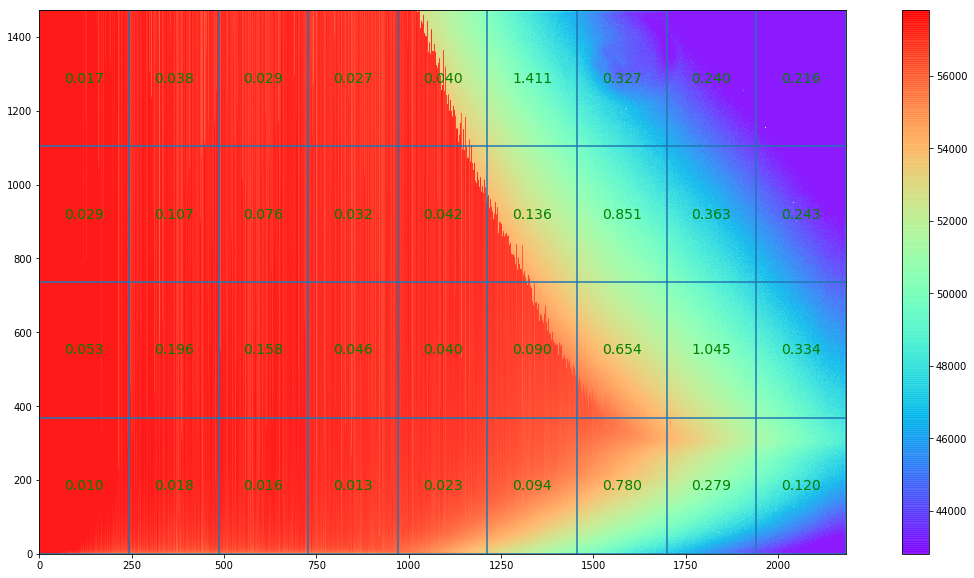

In [9]:
plt.figure(figsize=(20, 10))

# Use the imshow function to plot one of the flat images for reference.
plt.imshow(flat_1, vmin=np.percentile(flat_1, 5), vmax=np.percentile(flat_1, 90),
           origin='lower', cmap='rainbow', alpha=0.9, interpolation='nearest')


# Plot the boundaries of the subregions
for row in row_bins:
    plt.axhline(row)
for col in col_bins:
    plt.axvline(col)

# Print the local gain value in each subregion
for ii in range(len(row_bins) - 1):
    for jj in range(len(col_bins) - 1):
        row_loc = (row_bins[ii] + row_bins[ii + 1]) / 2
        col_loc = (col_bins[jj] + col_bins[jj + 1]) / 2
        
        plt.text(col_loc, row_loc, '{:.3f}'.format(gain_map[ii, jj]),
                 ha='center', va='center', fontsize=14, color='g')

plt.xlim(0, col_bins[-1])
plt.ylim(0, row_bins[-1])

# Add a colorbar
plt.colorbar()
plt.show()